<a id="top"></a>
# Topics Outline

## [Why are 2 interacting RR robots different than a 5barlinkage?](#5bl_explanation)
## [What does the most general 5 bar linkage look like?](#g5bl_model)
 - derivation
 - gen5barlinkage class definition
 - gen5barlinkage exploration tool
 - discussion points
 
## [What does the human model look like?](#human_model)
- derivation
- human class definition
- human model exploration tool. 
- discussion points

## [Joint exploration - put the two together](#joint_exp)
- joint exploration tool 

## [Solve the constrained optimization problem](#solution)

# [notes](#notes)


<a id="5bl_explanation"></a>
# Why are 2 interacting RR robots different than a 5-bar-linkage? [ &#x21ea;](#top)



# Utility class [ &#x21ea;](#top)

In [7]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

class utils:
    """
    utility functions shared between different classes
    """
    @staticmethod
    def dist(x1,y1,x2,y2):
        """
        calculate the distance between 2 points
        """
        return ((x2 - x1)**2 + (y2 - y1)**2)**.5
    
    @staticmethod
    def mkCircle(x0,y0,r,n = 100):
        t = np.linspace(0,2* np.pi,n)
        x = r * np.cos(t) + x0
        y = r * np.sin(t) + y0
        return x,y

    @staticmethod
    def circIntersection(x1,y1,r1,x2,y2,r2):
        """characterize circle intersection"""
        dx = x2-x1; dy = y2-y1
        hyp = (dx**2 + dy**2)**.5
        if hyp > (r1 + r2):
            intersect = False
        else:
            intersect = True
        ipt = (x1 + (dx/2), y1 + (dy/2))
        ang = np.arctan2(dy,dx)
        return (ipt,ang,intersect)

    @staticmethod
    def withinIntersection(x1,y1,r1,x2,y2,r2,pt):
        """is the point contained within the intersection or two circles?"""
        def within(x,y,r,pt):
            dx = pt[0] - x ; dy = pt[1] - y
            hyp = (dx**2 + dy**2)**.5
            return r > hyp

        return (within(x1,y1,r1,pt) and within(x2,y2,r2,pt))
    
    @staticmethod
    def ROC(θ,upper=None,lower=None):
        """
        rollover correction, to make sure the change in angle (Δθ) is accurately
        represented. the function can equally be used to find the minimal representation
        of an angle on the range (-π,π)
        """
        if upper == None: upper =  np.pi
        if lower == None: lower = -np.pi
            
        while (θ > upper) or (θ <=  lower):
            if     θ >  upper: θ -= 2*np.pi
            elif   θ <= lower: θ += 2*np.pi
        return θ
    
    @staticmethod
    def noNans(*args):
        for arg in args:
            if np.isnan(arg):
                return False
        return True
    
    @staticmethod
    def GD(x0,df,params):
        """
        peform gradient decent, given df, a function for calculating the 
        derivate of the function to be optimized. 
        """
        next_x = x0   # We start at x0
        gamma = 0.01  # Step size multiplier
        precision = 0.0001  # Desired precision of result
        max_iters = 10000  # Maximum number of iterations
        
        for _ in range(max_iters):
            current_x = next_x
            next_x = current_x - gamma * df(current_x,params)

            step = next_x - current_x
            if abs(step) <= precision:
                break

        return next_x


<a id="g5bl_model"></a>
# What does the most general 5 bar linkage look like? [ &#x21ea;](#top)  

###  below we see a parametric representation of the kinematics of a general 5 bar linkage:

<img src="./imgs/general5bl_designParams.svg" style="width:1600px">

### * if we allow $L_{0} = 0$ and attach the end effector to $L_{2}$ with a decent sized $P_{x}$ extension segment, and place $(y_1,x_1)$ at the hip joint and $e_1$ at the knee, then we have the "exoskeleton" like design
### taken together, theses 11 variables represent the parameter space over which our optimization will ocure


The forward kinematics equations are: 

<font size="7">
$$
\begin{align*} 
X_{ee} &= L_{1l}C_{1l} + L_{2l}C_{12l} + L_{13l}C_{123l} + X_l \\ 
Y_{ee} &= L_{1l}S_{1l} + L_{2l}S_{12l} + L_{13l}S_{123l} + Y_l \\
X_{jt} &= L_{1l}S_{1l} + L_{2l}S_{12l} + X_l \\
X_{jt} &= L_{1l}S_{1l} + L_{2l}S_{12l} + Y_l \\
X_{jt} &= L_{1r}S_{1r} + L_{2r}S_{12r} + X_r \\
X_{jt} &= L_{1r}S_{1r} + L_{2r}S_{12r} + Y_r \\
\end{align*}
$$
</font>

* there are configurations for solving FK
* there are 4 configurations for solving IK
* there are 4 jacobians for the parellel robot, corresponding to each of the 4 methods. 
* i want to visualize how this effects the reciprical condition number, using our visualization techniques. 
* currently, configuration switching is not being considered in the analysis. 
    * recall that changing configurations requires passing through a singularity
* should we allow links to cross? - how would we deal with this, besides setting the value to zero when the links cross? ( assign a crossing penalty function) (0-1)
* direct penalty of singularity ()? or again should we only penalize indirectly? 
    * it seems to me that a singularity in the middle of the workspace is way worse than a singularity at then edge of the workspace. if it becomes a problem, we can invent a criteria   to elimitinate it, else carry on.

In [43]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact , Layout , FloatSlider , Checkbox , Dropdown
from IPython.display import display
from numpy import linalg as LA
from shapely.geometry import Polygon
from IPython.core.debugger import set_trace

class Gen5barlinkage:
    """
    this general 5 bar linkage class solves the kinematics, inverse kinematics, and 
    differential kinematics (jacobian) of a 2DOF, 5 bar linkage which is parametrized
    to be as general a 5 bar linkage as possible. 
    
    design parameters: 
        states that do not change during the course of the inner-loop of the optimization
        function, and represent design decisions to be made about the robot
    
    state variables: 
        angles that define the state of robot at a particular position
    """
    def __init__(self):
        #---continuous design parameters -----------
        self.xl =  0
        self.yl =  0
        self.xr = .5
        self.yr =  0
        
        self.L0  = .25      #calculated
        self.L1l = .25      #left link 1
        self.L2l = .25      #left link 2
        self.L3l = .25      #left link 3 
        self.L1r = .25      #right link 1
        self.L2r = .25      #right link 2
        
        self.θ3l =  .25      #angle parameter on [0-2π]
        
        #------discrete design paramters ---------
        
        #effecting the IK
        self.e1 = 'up'  #[up or down]
        self.ef = 'up'  # the state of the ficticious elbow, a proxy for e1
        self.e3 = 'up'
        #self.e2 = 'up' //determined by IK
        
        #---------- state variables -----------
        self.θ1l = None
        self.θ2l = None
        self.θ1r = None
        self.θ2r = None
        
        self.Xee = None  #required for θ driven kinematics
        self.Yee = None  #required for θ driven kinematics
        
        #---------- torque variables ----------
        self.τ1l = 100  #[N*m]
        self.τ1r = 100  #[N*m]
        
        
    def L0update(L0,θ0):
        """
        helper function for changing the internal state x2,y2 based on the polar 
        parameterization, (L0,θ0)
        """
        #FK for polar parameterization
        self.xr = self.xl + L0*np.cos(θ0);
        self.yr = self.xl + L0*np.sin(θ0);
    
    
    
    def _IK_RRR(self,x,y):
        """
        perform Inverse Kinematics on an RRR robot (constituting the left side the 
        5bar linkage in the reference position), in terms of x,y,θ3 this is an analytical
        solution to the IK problem, that assumes θ3 is locked and uses a fictutious link (l_f)
        approach. 
        """
        #define local vars: 
        L1 = self.L1l; L2 = self.L2l; L3 = self.L3l; θ3 = self.θ3l
        
        #determine the wrist state based on θ3  (consider refactoring into a property?)
        θ3 = utils.ROC(θ3,lower = 0,upper = 2*np.pi)
        if θ3 >= 0 and θ3 < np.pi:
            wrist = "down"
        if θ3 >= np.pi and θ3 <= 2*np.pi:
            wrist = "up"
    
        #determine Lf, the length of the ficticious segment
        a = np.pi - θ3
        Lf = (L2**2 + L3**2 - 2*(L2)*(L3)*np.cos(a))**.5
        
        #determine the IK for the RR robot formed by L1 and the fictitious Lf 
        θ1, θ2f = self._IK_RR(x,y,L1,Lf,self.ef)
        
        #determine the FK to the first link 
        x1 = L1*np.cos(θ1); y1 = L1*np.sin(θ1)
        
        #determine the IK from the tip of the first link, to the end effector location
        θ2, θ3 = self._IK_RR(x - x1,y - y1,L2,L3,wrist)
        θ2 -= θ1                             #angle correction for different coordinate frames 
        
        return θ1,θ2,θ3
    
    
        
    def _IK_RR(self,x,y,l1,l2,elbow):
        """
        perform Inverse Kinematics on an RR robot, see lect5 p.9-10 
        """
        #solve for intermediate values
        r = utils.dist(0,0,x,y)
        β = np.arccos((l1**2 + l2**2 - r**2) / (2*l1*l2))
        γ = np.arccos((r**2 + l1**2 - l2**2) / (2*r*l1))
        α = np.arctan2(y,x)
        
        #handle different elbow states
        θ1 = α - γ
        θ2 = np.pi - β
        
        if elbow == "down":
            return θ1,θ2
        elif elbow == "up":
            θ1pm = θ1 + 2*γ  
            θ2pm = -θ2   
            return θ1pm,θ2pm
        
    
    
    def _FK_RRR(self,θ1,θ2,θ3,l1,l2,l3):
        """
        forward kinematics for the an RRR robot
        """
        s1  = np.sin(θ1)      ; c1  = np.cos(θ1)
        s12 = np.sin(θ1 + θ2) ; c12 = np.cos(θ1 + θ2)
        s123 = np.sin(θ1 + θ2 + θ3) ; c123 = np.cos(θ1 + θ2 + θ3)
    
        #forward kinematics
        origin = [0,0]
        l1_tip = [l1*c1 , l1*s1]                                     
        l2_tip = [l1_tip[0] + l2*c12, l1_tip[1] + l2*s12]
        l3_tip = [l2_tip[0] + l3*c123, l2_tip[1] + l3*s123]
        
        #reorganize into vectors
        x = [origin[0],l1_tip[0],l2_tip[0],l3_tip[0]]
        y = [origin[1],l1_tip[1],l2_tip[1],l3_tip[1]]
        
        return x,y
    
    
    
    def _FK_RR(self,θ1,θ2,l1,l2):
        """
        forward kinematics for RR robot
        """
        x,y = self._FK_RRR(θ1,θ2,0,l1,l2,0)
        return x[:-1],y[:-1]
    
    
    
    def IK5bl(self,x,y):
        """
        calculate the inverse kinematics for the entire 5-bar-linkage robot. 
        """
        #see if the left RRR robot can reach the target point with the end effector
        θ1l,θ2l,θ3l = self._IK_RRR(x - self.xl,y - self.yl)
        
        #calculate the position of joint e2
        xs,ys = self._FK_RR(θ1l,θ2l,self.L1l,self.L2l)                    #local to RRR link
        xe2 = xs[2] + self.xl; ye2 = ys[2] + self.yl                      #global frame
        
        #calculate the IK for tip of the right RR robot to the point E2
        θ1r,θ2r = self._IK_RR(xe2 - self.xr,ye2 - self.yr,self.L1r,self.L2r,self.e3)
        
        #update internal representation of state
        self.θ1l,self.θ2l,self.θ1r,self.θ2r  =  θ1l,θ2l,θ1r,θ2r 
        self.Xee = x; self.Yee = y
        
        return θ1l,θ2l,self.θ3l,θ1r,θ2r 
    
    
    
    def θdrivenKinematics5bl(self,θ1l,θ1r):
        """
        given an initial system configuration (which is taken to be the internal state)
        numerically solve the system when either θ1 or θ2 are driven by some (small) amount. 
        this is to get an sense for what the FK will look like when driving via the actuators
        """
        #assume at least 1 call has been made to IK5bl, and therefore the system has been initialized
        q = np.array([self.Xee,self.Yee,self.θ2l,self.θ2r])
        self.θ1l = θ1l; self.θ1r = θ1r  #update state with targets
        
        def Φ(q):
            """
            system of non-linear equations constituting the FK of the gen5bl
            """
            #extract variables from q
            Xee = q[0]; Yee = q[1]
            θ2l = q[2]; θ2r = q[3] 
            
            #static values
            θ1l = self.θ1l ; θ1r = self.θ1r ; θ3l = self.θ3l 
            
            #forward kinematics to the end effector
            xs,ys = self._FK_RRR(θ1l,θ2l,θ3l,self.L1l,self.L2l,self.L3l)
            eq1 = xs[3] + self.xl - Xee
            eq2 = ys[3] + self.yl - Yee
            
            #left and right robots meet at a joint
            xls , yls = self._FK_RR(θ1l,θ2l,self.L1l,self.L2l)
            xrs , yrs = self._FK_RR(θ1r,θ2r,self.L1r,self.L2r)
            eq3 = xls[2] + self.xl - xrs[2] - self.xr
            eq4 = yls[2] + self.yl - yrs[2] - self.yr
            
            ϕ = np.array([[eq1],[eq2],[eq3],[eq4]])
            return ϕ
        
        
        def Φ_q(q):
            """
            derivative of Φ w.r.t the variables q
            """
            #extract variables from q
            Xee = q[0]; Yee = q[1]
            θ2l = q[2]; θ2r = q[3] 
            
            #static values
            θ1l = self.θ1l ; θ1r = self.θ1r ; θ3l = self.θ3l  
            
            #compute sines and cosines
            s12l  = np.sin(θ1l + θ2l)        ; c12l  = np.cos(θ1l + θ2l)
            s123l = np.sin(θ1l + θ2l + θ3l)  ; c123l = np.cos(θ1l + θ2l + θ3l)
            s12r  = np.sin(θ1r + θ2r)        ; c12r  = np.cos(θ1r + θ2r)
            
            #form the jacobian explicitly
            #                Xee   Yee                 θ2l                       θ2r
            ϕ_q = np.array([[-1,    0,   -self.L2l*s12l - self.L3l*s123l,         0     ],   #eq1
                            [ 0,   -1,    self.L2l*c12l + self.L3l*c123l,         0     ],   #eq2
                            [ 0,    0,   -self.L2l*s12l,                  self.L2r*s12r ],   #eq3
                            [ 0,    0,    self.L2l*c12l,                 -self.L2r*c12r ]])  #eq4
            
            return ϕ_q
            
            
        #perform Newton-Rhapson
        Δq = np.ones([4])
        ϵ = 10**-7 
        maxIter = 100
        n = 0
        while np.linalg.norm(Δq) > ϵ:
            #print(Φ_q(q))
            Δq = np.linalg.solve(Φ_q(q), -Φ(q))
            q = q + Δq.squeeze()
            n +=1
            if n > maxIter:
                break
        
        #set state variables (for next time around) and return
        self.Xee = q[0] ; self.Yee = q[1]; self.θ2l = q[2]; self.θ2r = q[3]
        return self.θ1l,self.θ2l,self.θ3l,self.θ1r,self.θ2r  #for FK plot
        
        
    
    def FKplot5bl(self,θ1l,θ2l,θ3l,θ1r,θ2r):
        """
        given the joint angles, what are the points to plot to view the robot?
        return the points as 3 objects so they can be plotted in different styles
        """
        xs,ys = self._FK_RRR(θ1l,θ2l,θ3l,self.L1l,self.L2l,self.L3l)        #local to RRR link
        xs = self.xl + np.array(xs) ; ys = self.yl + np.array(ys)           #global frame
        
        left        = (xs,ys)
        
        xs,ys = self._FK_RR(θ1r,θ2r,self.L1r,self.L2r)                      #local frame
        xs = self.xr + np.array(xs) ; ys = self.yr + np.array(ys)           #global frame
        
        right = (xs,ys)
        
        return left,right
        
        
        
    def Jac(self,x,y,mode = "force"):
        """
        calculate the jacobian matrix at position x,y, given the elbow states. 
        """
        #calculate the IK for the given state of the elbows, and x,y
        θ1l,θ2l,θ3l,θ1r,θ2r  =  self.IK5bl(x,y)
        
        #define sine's and cosines, lengths
        c123l =  np.cos(θ1l + θ2l + θ3l) ; s123l = np.sin(θ1l + θ2l + θ3l)
        c1r   =  np.cos(θ1r)             ; s1r   = np.sin(θ1r) 
        c12r  =  np.cos(θ1r + θ2r)       ; s12r  = np.sin(θ1r + θ2r)
        L3l = self.L3l; L1r = self.L1r; L2r = self.L2r
        
        #calculate the force jacobian 
        #                  x(θ's)                  y(θ's)  
        jac = np.array([[-L3l*s123l          , L3l*c123l        ],      #θ1l
                        [-L1r*s1r - L2r*s12r , L1r*c1r + L2r*c12r]])    #θ1r
        
        if mode == "force":
            return jac
        elif mode == "velocity":
            return jac.T
    
    def J_invT(self,x,y):
        """
        calculate the Inverse Transpose Jacobian which is used to map joint torques [τ1l, τ1r]
        to end effector forces, using the method of finite differences from the analytical IK
        """
        
        #calculate the sensitivity of IK to changes in x and y with finite differences
        δ = .0005
        #col 1
        θ1l_p,__,__,θ1r_p,__  =  self.IK5bl(x+δ,y)
        θ1l_m,__,__,θ1r_m,__  =  self.IK5bl(x-δ,y)
        δθ11 = θ1l_p - θ1l_m
        δθ21 = θ1r_p - θ1r_m
        
        #col 2
        θ1l_p,__,__,θ1r_p,__  =  self.IK5bl(x,y+δ)
        θ1l_m,__,__,θ1r_m,__  =  self.IK5bl(x,y-δ)
        δθ12 = θ1l_p - θ1l_m
        δθ22 = θ1r_p - θ1r_m
        
        #assemble in inverse jacobian
        δx = 2*δ ; δy = 2*δ
        #                        x       y
        J_inv = np.array([[δθ11/δx , δθ12/δy ],    #θ1l 
                          [δθ21/δx , δθ22/δy]])    #θ1r
        
        
        return J_inv.T
        
    def J_vel_analytical(self,x,y,jac = "J"):
        """
        using the method of velocity loop closure, jacobians were determined analytically
        for the Gen5bl system under the following assumptions:
        x = [Xee,Yee,ϕ]
        θ = [θ1l,θ1r]
        """
        
        
        if jac == "Jq":
            pass
        if jac == "Jx":
            pass
        
        if Jac == "J":
            pass
        
        
    def bounds(self,leftTrimmed = False):
        """
        using an analytical approach, find the boundry where it's possible to solve IK.
        the boundry in space where IK is solveable is defined by where the end effector is
        when one of the two grounded serial robots is at full extension. for the left robot,
        this is simply a circle. for the right robot, its a more complicated shape.
        """
        #calculate the effective radii of the left and right robots
        a = np.pi - self.θ3l
        Lf = (self.L2l**2 + self.L3l**2 - 2*(self.L2l)*(self.L3l)*np.cos(a))**.5
        Rl = self.L1l + Lf
        Rr = self.L1r + self.L2r
        
        #make a set of points for the circular boundries of each arm
        xl = self.xl ; yl = self.yl; xr = self.xr ; yr = self.yr
        ϵ = .0001; #need a little numerical cushion to get all the points
        Lbx,Lby = utils.mkCircle(xl,yl,Rl - ϵ)
        Rx,Ry = utils.mkCircle(xr,yr,Rr - ϵ)
        
        #only include the left bondry points that can be reached through gen5bl IK
        if leftTrimmed:
            _Lbx = [] ; _Lby = []
            for i,x in enumerate(Lbx):
                θ1l,θ2l,θ3l,θ1r,θ2r = self.IK5bl(Lbx[i] - xl,Lby[i] - yl)
                if not np.isnan(θ1r) and not np.isnan(θ2r): 
                    _Lbx.append(Lbx[i])
                    _Lby.append(Lby[i])       
            Lbx = _Lbx; Lby = _Lby
        
       #for right robot full extension, perform IK to joint e2, then FK on Left side
        Rbx = [] ; Rby = []
        for i,x in enumerate(Rx):
            θ1,θ2 = self._IK_RR(Rx[i] - xl,Ry[i] - yl,self.L1l,self.L2l,self.ef)
            if  not np.isnan(θ1) and not np.isnan(θ2):
                xs,ys = self._FK_RRR(θ1,θ2,self.θ3l,self.L1l,self.L2l,self.L3l)
                x = xs[3] + xl ; y = ys[3] + yl
                Rbx.append(x)
                Rby.append(y)
            
        
        
        return (Lbx,Lby),(Rbx,Rby) 
                
                
    def boundingBox(self):
        """
        calculate the cartesian bounding box where solving IK is feasable
        output: xmin,xmax,ymin,ymax
        """
        ls,rs = self.bounds(leftTrimmed = True)
        xs = np.hstack([ls[0],rs[0]])
        ys = np.hstack([ls[1],rs[1]])
        δ = .1
        xmin = np.min(xs)-δ ; xmax = np.max(xs)+δ
        ymin = np.min(ys)-δ ; ymax = np.max(ys)+δ        
        return xmin,xmax,ymin,ymax
    
    
    def condGrid(self,nx = 20,ny = 20,clean=False):
        """
        evaluate the reciprical condition number on a grid within the reachable
        space of the gen5bl robot
        """
        #setup sampling vectors
        xmin,xmax,ymin,ymax = self.boundingBox()
        X = np.linspace(xmin,xmax,nx)
        Y = np.linspace(ymin,ymax,ny)
    
        #evaluate reciprical condition number
        Z = np.zeros((X.shape[0],Y.shape[0]))
        Z = np.full_like(Z, np.nan)
        if clean: return X,Y,np.full_like(Z,np.nan)
        for i,x in enumerate(X):
            for j,y in enumerate(Y):
                invCond = 1/np.linalg.cond(self.J_invT(x,y))
                Z[i,j] = invCond
        return X,Y,Z.T
    
        
        
        
        
#---------------------------------- plotting ---------------------------------
R = Gen5barlinkage()

#setup contour plot for condition number 
#colorscale = [[0, 'green'],[.2,'royalblue'],[1, 'blue']]
colorscale = [[0, 'green'],[1, 'blue']]
X,Y,Z = R.condGrid()
_fig = go.Figure(data = go.Contour(z=Z,x=X,y=Y,colorscale=colorscale,contours_coloring='heatmap'))
Rfig = go.FigureWidget(_fig)
#Rfig = go.FigureWidget()

#configure layout of graph
Rfig.update_xaxes(range=[-1,1])
Rfig.update_yaxes(range=[-1,1])

side = 800
Rfig.update_layout(
    autosize=False,
    width=side + 100,
    height=side,
    legend=dict(x=.025, y=.975),
    margin=dict(l=80, r=80, t=0, b=80))


#initialize all plots present in visualization
Rfig.add_scatter(line=dict(color='royalblue'), name = "left")
Rfig.add_scatter(line=dict(color='red'), name = "right")
Rfig.add_scatter(mode='markers', marker=dict(size=12,color="black"), name = "End Effector")
Rfig.add_scatter(line=dict(dash='dash',color='royalblue'), name = "RRR boundry")
Rfig.add_scatter(line=dict(dash='dash',color='red'), name = "RR boundry")
# hfig.add_scatter(mode="markers", marker = dict(color = np.linspace(0,1,50*25)),name="boundrySample")
# hfig.add_scatter(line=dict(color='royalblue'),name = "leg")
# hfig.add_scatter(mode="markers", name = "forceSpace")


#setup UI
layout=Layout(width='500px', height='20px')
layout1=Layout(width='200px', height='30px')
layout2=Layout(width='350px', height='30px')
lmin = .1 ; lmax = .75; lval = .25
rng = 1; step = .001
N = 0


#modes
ef     = Dropdown(options=["up","down"],value="up",description='ef',layout=layout1)
e3     = Dropdown(options=["up","down"],value="up",description='e3',layout=layout1)
mode   = Dropdown(options=["None","boundry","cond"],value="None",description='Mode',layout=layout1)
drive  = Dropdown(options=["xy","θ"],value="xy",description='drive',layout=layout1)
fsView = Checkbox(value=False,description="fsView",dindent=False,layout=layout1)


#params
L1l = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L1_l', layout=layout2)
L2l = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L2_l', layout=layout2)
L3l = FloatSlider(min=0   ,max=lmax,step=step,value=lval,description='L3_l', layout=layout2)

L1r = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L1_r', layout=layout2)
L2r = FloatSlider(min=lmin,max=lmax,step=step,value=lval,description='L2_r', layout=layout2)
θ3l = FloatSlider(min=-rng,max=lmax,step=step,value=lval,description='θ3_l', layout=layout2)

xl = FloatSlider(min=-rng,max=rng,step=step,value=.0,description='x_l', layout=layout)
xr = FloatSlider(min=-rng,max=rng,step=step,value=.5,description='x_r', layout=layout)

yl = FloatSlider(min=-rng,max=rng,step=step,value=.0,description='y_l', layout=layout)
yr = FloatSlider(min=-rng,max=rng,step=step,value=.0,description='y_r', layout=layout)

#drivers
θ1l = FloatSlider(min=-np.pi,max=np.pi,step=step,value=.0,description='θ1_l', layout=layout)
xee = FloatSlider(min=-rng,max=rng,step=step,value=.5,description='xee', layout=layout)

θ1r = FloatSlider(min=-np.pi,max=np.pi,step=step,value=.0,description='θ1_r', layout=layout)
yee = FloatSlider(min=-rng,max=rng,step=step,value=.5,description='yee', layout=layout)

#assemble UI
row1 = widgets.HBox([ef,e3,mode,drive,fsView])
row2 = widgets.HBox([L1l,L2l,L3l])
row3 = widgets.HBox([L1r,L2r,θ3l])
row4 = widgets.HBox([xl,xr])
row5 = widgets.HBox([yl,yr])
row6 = widgets.HBox([θ1l,xee])
row7 = widgets.HBox([θ1r,yee])

ui = widgets.VBox([row1,row2,row3,row4,row5,row6,row7])


#define and register observer function to link possible driving variables
# def updateθs(*args):
#     #_θ1l,_θ2l,_θ3l,_θ1r,_θ2r = R.IK5bl(xee.value,yee.value)
#     #θ11.value = _θ1l ; θ1r.value = _θ1r
#     θ11.value = xee.value ; θ1r.value = yee.value
    
# def updateEEs(change):
#     R.θdrivenKinematics5bl(θ11.value,θ1r.value)
#     xee.value,yee.value = R.Xee,R.Yee 
    
#θ1l.observe(updateEEs, 'value')
#θ1r.observe(updateEEs, 'value')
# xee.observe(updateθs)
# yee.observe(updateθs)


#setup update function
wdict = {"ef":ef,"e3":e3,"mode":mode,"drive":drive,"fsView":fsView,
         "L1l":L1l,"L2l":L2l,"L3l":L3l,
         "L1r":L1r,"L2r":L2r,"θ3l":θ3l,
         "xl":xl,"xr":xr,
         "yl":yl,"yr":yr,
         "_θ1l":θ1l,"_xee":xee,
         "_θ1r":θ1r,"_yee":yee}


def update(ef="up",e3="up",mode="None",drive="xy",fsView=False,
           L1l=1,L2l=1,L3l=1,
           L1r=1,L2r=1,θ3l=1,
           xl=0,xr=1,
           yl=0,yr=1,
           _θ1l=1,_xee=1,    #use _ so we have access to the slider objects
           _θ1r=1,_yee=1):
    
    with Rfig.batch_update():
        
        #update parameters
        global R
        R.ef = ef ; R.e3 = e3
        R.L1l = L1l ; R.L2l=L2l ; R.L3l = L3l
        R.L1r = L1r ; R.L2r=L2r ; R.θ3l = θ3l
        R.xl = xl ; R.xr = xr
        R.yl = yl ; R.yr = yr
        
        #calculate the robot's configuration
        if drive == "xy":
            _θ1l,_θ2l,_θ3l,_θ1r,_θ2r = R.IK5bl(_xee,_yee)
            left,right = R.FKplot5bl(_θ1l,_θ2l,_θ3l,_θ1r,_θ2r)
            
            #keep θ's up to date for solving numberical IK
            if utils.noNans(_θ1l,_θ1r):
                global θ1l ; global θ1r
                θ1l.value = utils.ROC(_θ1l); θ1r.value = utils.ROC(_θ1r)
            
        if drive == "θ":
            _θ1l,_θ2l,_θ3l,_θ1r,_θ2r = R.θdrivenKinematics5bl(_θ1l,_θ1r)
            left,right = R.FKplot5bl(_θ1l,_θ2l,_θ3l,_θ1r,_θ2r)
            
        #draw the robot (if solution exists)
        Rfig.data[1]['x'] = left[0]
        Rfig.data[1]['y'] = left[1]

        Rfig.data[2]['x'] = right[0]
        Rfig.data[2]['y'] = right[1]  

        #plot a dot at the end effector location
        Rfig.data[3]['x'] = [_xee]
        Rfig.data[3]['y'] = [_yee]
       
        
        
        #draw the force space 
        
        #draw the reachable boundry
        if mode == "boundry" or mode == "cond":
            ls,rs = R.bounds()
            Rfig.data[4]['x'] = ls[0]
            Rfig.data[4]['y'] = ls[1]
    
            Rfig.data[5]['x'] = rs[0]
            Rfig.data[5]['y'] = rs[1]
        
        #draw a contour plot of the reciprical condition numer 
        if mode == "cond":
            X,Y,Z = R.condGrid()
            Rfig.data[0]['x'] = X
            Rfig.data[0]['y'] = Y
            Rfig.data[0]['z'] = Z  
        
        #clean up 
        if mode == "None":
            #clean up contour plot (this nukes R state)
            X,Y,Z = R.condGrid(clean=True)
            Rfig.data[0]['x'] = X
            Rfig.data[0]['y'] = Y
            Rfig.data[0]['z'] = Z
            
            #clean up boundry
            Rfig.data[4]['x'] = []
            Rfig.data[4]['y'] = []
            
            Rfig.data[5]['x'] = []
            Rfig.data[5]['y'] = []
            
        #reset R state properly
        R.IK5bl(_xee,_yee)
        
        
        


#display interactive figure
out = widgets.interactive_output(update, wdict)
display(ui)
Rfig


FigureWidget({
    'data': [{'colorscale': [[0, 'green'], [1, 'blue']],
              'contours': {'coloring':…

In [9]:
_θ1l,_θ2l,_θ3l,_θ1r,_θ2r = R.IK5bl(.42,3)
left,right = R.FKplot5bl(_θ1l,_θ2l,_θ3l,_θ1r,_θ2r)
left[1][3]

nan

In [10]:
out

Output()

In [39]:
%timeit R.J_invT(.25,.25)

260 µs ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
R.θdrivenKinematics5bl(1.25,2.74)

(1.25, -0.802835680460293, 0.25, 2.74, -1.307078967490014)

In [33]:
x = np.linspace(1.25,2.0,20)
for xi in x:
    print(R.θdrivenKinematics5bl(xi,2.74))

(1.25, -0.8028356804602945, 0.25, 2.74, -1.3070789674900145)
(1.2894736842105263, -0.8506858192563839, 0.25, 2.74, -1.272721909663702)
(1.3289473684210527, -0.8981059457475756, 0.25, 2.74, -1.2378099436701389)
(1.368421052631579, -0.94515333422004, 0.25, 2.74, -1.2023977025903203)
(1.4078947368421053, -0.9918777798401592, 0.25, 2.74, -1.1665311688408715)
(1.4473684210526316, -1.0383229767405313, 0.25, 2.74, -1.1302490909782053)
(1.486842105263158, -1.084527632706562, 0.25, 2.74, -1.0935841054079032)
(1.526315789473684, -1.1305263816125708, 0.25, 2.74, -1.0565636272100818)
(1.5657894736842106, -1.1763505400758618, 0.25, 2.74, -1.0192105579730044)
(1.6052631578947367, -1.222028744163511, 0.25, 2.74, -0.9815438464846667)
(1.6447368421052633, -1.2675874942655463, 0.25, 2.74, -0.9435789291009942)
(1.6842105263157894, -1.313051630663439, 0.25, 2.74, -0.9053280697025907)
(1.7236842105263157, -1.3584447583446728, 0.25, 2.74, -0.8668006137334682)
(1.763157894736842, -1.4037896368869032, 0.25, 2

In [27]:
R.θdrivenKinematics5bl(0,2.74)

(0, 40.43911184307752, 0.25, 2.74, -49.8638898038469)

### high definition condition number portrait

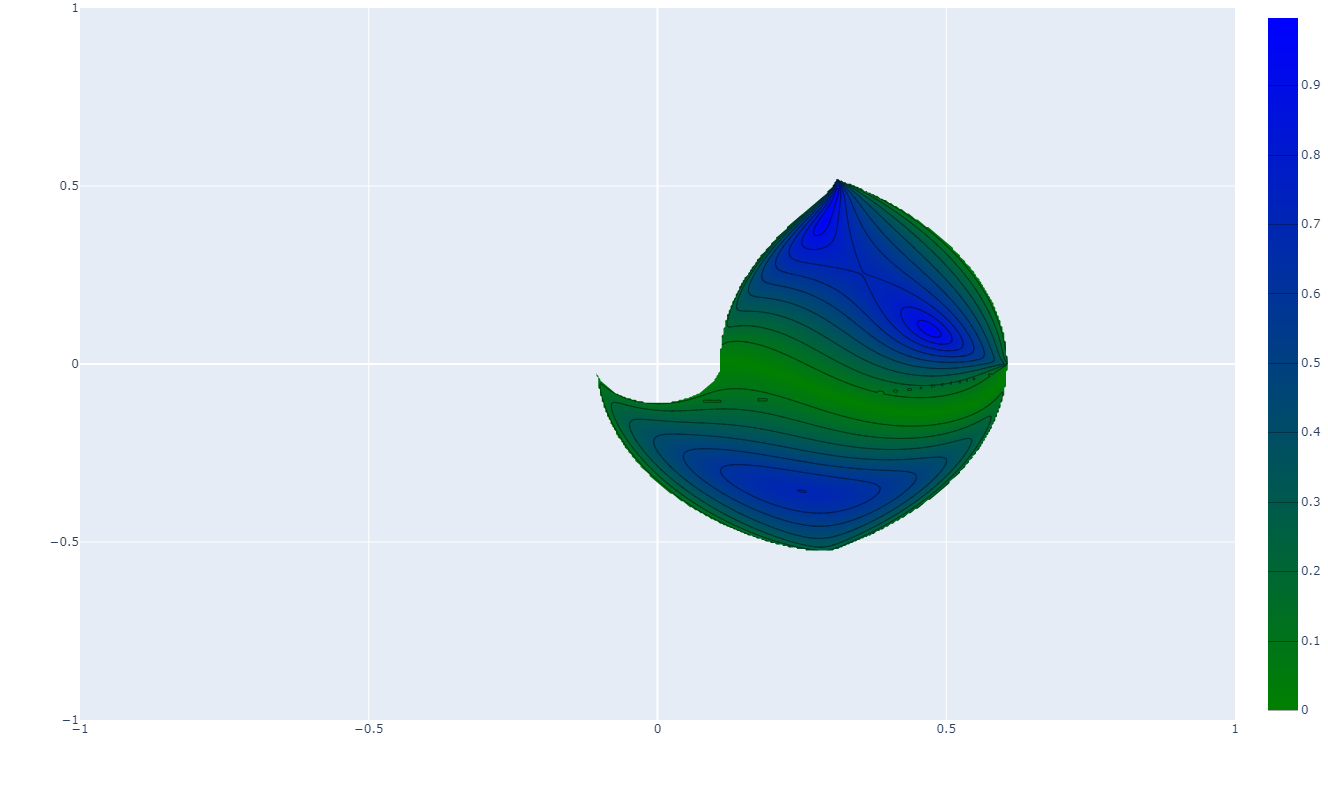

In [44]:
colorscale = [[0, 'green'],[1, 'blue']]
X,Y,Z = R.condGrid(nx=300,ny=300)
HD_fig = go.Figure(data = go.Contour(z=Z,x=X,y=Y,colorscale=colorscale,contours_coloring='heatmap'))
HD_fig

#config layout
side = 800
HD_fig.update_layout(
    autosize=False,
    width=side + 100,
    height=side,
    legend=dict(x=.025, y=.975),
    margin=dict(l=80, r=80, t=0, b=80))

#configure layout of graph
HD_fig.update_xaxes(range=[-1,1])
HD_fig.update_yaxes(range=[-1,1])



In [70]:
np.save("./bin/Zed.npy",Z)

In [68]:
Z

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [61]:
import plotly.graph_objects as go
img_rgb = [[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
           [[0, 255, 0], [0, 0, 255], [255, 0, 0]]]
fig = go.Figure(go.Image(Z))
fig.show()

ValueError: The first argument to the plotly.graph_objs.Image 
constructor must be a dict or 
an instance of :class:`plotly.graph_objs.Image`

In [16]:
x = FloatSlider(min=0.0, max=10.0, step=0.05)
y = FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

ui = widgets.VBox([x_widget,y_widget])

def update_x_range(change):
    x.value = 2.0 * y.value

y.observe(update_x_range)

def printer(x, y):
    print(x, y)

#interact(printer,x=x_widget, y=y_widget);
wdict = {"x":x,"y":y}

out = widgets.interactive_output(printer, wdict)
display(ui)



In [ ]:
x_widget = FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)
x = 22;

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value

y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)
interact(printer,x=x_widget, y=y_widget);

### Discussion Points:
* joint limits on $\theta_1$ and $\theta_2$ or joint impingement? 
* link crossing? 
* ground plane? 
* $L_0$ constraint? 



to do: 
* draw Ef in the robot parameterization figure
* make a contour plot of the inverse condition number to check it's integrety
* make a numerical solver for running the system in $\theta_1, \theta_2$ drive mode
* add the code to compute the force trapizoid
* view the force trapezoid when fsview is selected





what are our objectives with this visualizer? 
* ensure that everything we have done is correct, and there are no errors, especially in the calculation of the IK and the jacobian. 
* evaluate the effects of changing different parameters on outputs like 
    *the reachable workspace
    *the reciprical condition number of the jacobian. 
* therefore, we want 
* want a way to drive the robot either with x and y (relative to drive it with theta's)
* view the force trapezoid
* view the inverse condition number. 
* adjust the states of the elbows. 



<a id="human_model"></a>
# what does the human model look like? [ &#x21ea;](#top)

<img src="./imgs/humanModel.svg" style="width:1700px">


### Discussion Points:
### IK - approaches to making IK realistic
* define springs and minimize a potential energy function
* develop a huristic for $ϕ(x,y)$
* bounds coupling


## to do:
(saturday) 
 - have fun, be creative, speed. 
 - write jacobian function X
 - implement hard limits on the joints using repulsion functions
 - tune linear model (figureing out why x0 isn't working exactly as you anticipated) so that it's good over the desired workspace
 - develop, train, store and compare the surigate model
 - finish the leg model visual
 
(sunday)
 - develop a first principles based bounds function which is quick to evaluate
 - develop and tune spline based torque classes (from literature / opensim?) 
 - implement mapping forward through the jacobian into the force space
 - visualize the force space, bounds, IK, all together -> the human model is good to go. 

<!-- $$
\begin{align}
τ_{h} &= f(θ_{h},θ_{k}) \\
τ_{k} &= f(θ_{h},θ_{k},θ_{a}) \\
τ_{a} &= f(θ_{k},θ_{a})
\end{align}
$$ -->

In [24]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact , Layout , FloatSlider , Checkbox , Dropdown
from IPython.display import display
from numpy import linalg as LA
from shapely.geometry import Polygon
from scipy.spatial import ConvexHull
from scipy.optimize import minimize

    
##design decision - should I treat Human more functionally - so basically as a static class, but without state, and more of a container for functions, or should I rely heavily 
#on state caching, which means I have to guarentee order of function calls inorder for things to be up to date. this is the fundemental tradeoff of functional vs stateful approaches. 
# other design decisions, would sampling happen in cartesian, or in joint space for the optimization? - at least some of that sampling should live in another class that handles the
#optimization between the human aand the 

class JointSpring:
    def __init__(self,θo,K,θmin,θmax):
        self.θo = θo;
        self.K = K;
        self.θmin = θmin
        self.θmax = θmax
        
        
    def PE(self,θ,mode = "linear"):
        """
        calculates and return the potential energy of the 
        spring given the angular displacement θ and the 
        """
        if mode == "linear":
            return .5 * self.K * (θ - self.θo)**2
        elif mode == "quadratic":
            return (1/3) * self.K *(θ - self.θo)**3
        elif mode == "softLimits":
            pass
        else:
            raise ValueError("mode {} not yet implemented".format(mode))
    
    def RepFieldPE(Δθ):
        θ0 = 0
        Δθ = θ - θ0
        ρ0 = 10 #[spring effective radius]
        ni = 100

        if Δθ > ρ0:
            return 0

        elif Δθ <= ρ0:
            Uri = 1/2 * ni * (1/Δθ - 1/ρ0)**2
            return Uri
        
    
    def penaltyFxn(self,θ):
        """
        potential energy function preventing joints from reaching their limits.
        this will take the form of a logistic function occupying joint regions 
        between the bounds. 
        """
         
        Δθ = utils.ROC(θ-self.θo)
        L = 1000                   #peak energy value 
        kdeg = 1                   #degrees
        K = 1/(np.pi/180 * kdeg)   #(1/rad) - logistic growth rate or spatial constant
        Pwidth = 20                 #width of flat portion in degrees
        dx = (Pwidth / 2) + 3 * (1 / K) #distance from pCenter to x0 or x1

        if delta <= 0:  #left of center
            tau = L / ( 1 + np.exp(-K*(delta + dx)))
        elif delta > 0: #right of center
            tau =  L - (L / ( 1 + np.exp(-K*(delta - dx))))
        
        self.torque = tau;
        return (2, self.torque)
        
    def visualizeEnergyFunction(self,mode = "PE"):
        """
        check with a graph that things are correct, including the spring
        energy function and the penalty function
        """
        xs = np.linspace(-np.pi,np.pi,1000)
        spring_fig = go.Figure()
        
        if mode == "PE" or mode =="both":
            ys = [self.PE(x) for x in xs]
            spring_fig.add_scatter(x=xs,y=ys)
        if mode == "spring" or mode == "both":
            ys = [self.penaltyFxn for x in xs]
            spring_fig.add_scatter(x=xs,y=ys)
            

class Human:
    def __init__(self):
        #segment lengths
        self.femur = .4075    #[meters - from anthopometric tables] 
        self.shank = .390     #[meters] 
        self.foot = .255      #[meters]
        self.reach = self.femur + self.shank + self.foot/2
        
        #joint limits
        self.θh_max = np.pi/180 *  90
        self.θh_min = np.pi/180 * -90
        self.θk_max = np.pi/180 *  0
        self.θk_min = np.pi/180 * -120
        self.θa_max = np.pi/180 * 90
        self.θa_min = np.pi/180 * 10
        
        self.αCheck = True  #make bounds a disk segment w/ alpha lims?
        self.α_max = np.pi/180 *  10
        
        #IK joint springs
        self.θhSpring = JointSpring(0,.001,self.θh_min,self.θh_max)
        self.θkSpring = JointSpring(0,.5,self.θk_min,self.θk_max)
        self.θaSpring = JointSpring(-np.pi/2,2,self.θa_min,self.θa_max)
        
        #state:
        self.θh = 0
        self.θk = 0
        self.θa = 0 
        

        
    #------------- private functions --------------------    
    def _IK_analytical(self,x_e,y_e,ϕ):
        """
        given a midfoot location and an orientation, return the joint angles
        by solving the analytical IK with wrist - end effector separation
        based on lect5 kinematics - slides 9-10
        """
        #define link lengths
        l1=self.femur
        l2=self.shank
        l3=self.foot/2
        
        #solve first for the wrist location
        x_w = x_e - l3*np.cos(ϕ)
        y_w = y_e - l3*np.sin(ϕ)
        
        #solve for intermediate values
        r = utils.dist(0,0,x_w,y_w)
        β = np.arccos((l1**2 + l2**2 - r**2) / (2*l1*l2))
        γ = np.arccos((r**2 + l1**2 - l2**2) / (2*r*l1))
        α = np.arctan2(y_w,x_w)
        
        #calculate θ's 
        θ1 = α - γ
        θ2 = np.pi - β
        θ3 = ϕ - θ1 - θ2
        
        #calc θ_primes for elbow up config
        θ1pm = θ1 + 2*γ  
        θ2pm = -θ2                      
        θ3pm = θ3 + 2*(θ2 - γ)
        
        return θ1pm,θ2pm,θ3pm
    
    
    def _IK_energy_fxn(self,θh,θk,θa):
        """
        defines the potential energy landscape
        """
        pe_h = self.θhSpring.PE(θh,mode = "linear")
        pe_k = self.θaSpring.PE(θk,mode = "linear")
        pe_a = self.θkSpring.PE(θa,mode = "linear")
        
        return pe_h + pe_k + pe_a
    
    def _energy_grad(self,ϕ,params):
        """
        calculate the gradient of the energy function using 
        finite differences for use in gradient decent
        """
        x = params[0] ; y = params[1]
        δ = .0001
        δm_θh,δm_θhk,δm_θa = self._IK_analytical(x,y,ϕ - δ)
        δp_θh,δp_θhk,δp_θa = self._IK_analytical(x,y,ϕ + δ)
        
        δmPE = self._IK_energy_fxn(δm_θh,δm_θhk,δm_θa)
        δpPE = self._IK_energy_fxn(δp_θh,δp_θhk,δp_θa)
        
        return -(δpPE - δmPE) / 2*δ
    
    def _IK_scipy_obj_fxn(self,ϕ,x,y):
        """defines an objective function for scipy.optimize.minimize"""
        θh,θk,θa = self._IK_analytical(x,y,ϕ)
        return self._IK_energy_fxn(θh,θk,θa)   
    
    
    def IK(self,x,y,method = "analytical"):
        """
        given a location x,y of the midfoot, what are the joint angles required to
        achieve that position? 
        """
        #check that IK can be performed
        #don't consider reaching just the foot
        if utils.dist(0,0,x,y) > self.femur + self.shank:
            return np.nan
        
        #method == analytical -> 3ms per evaluation...can we do better? 
        #determine ϕ of least potential energy
        if method == "analytical":
            ϕ_guess = self.θhSpring.θo + self.θkSpring.θo + self.θaSpring.θo
            res = minimize(self._IK_scipy_obj_fxn,(ϕ_guess),(x,y), method = 'nelder-mead')
            ϕ_min = res.x[0]
            θh,θk,θa = self._IK_analytical(x,y,ϕ_min)
            return θh,θk,θa
#             ϕ_min = utils.GD(ϕ_guess,self._energy_grad,(x,y))
#             θh,θk,θa = self._IK_analytical(x,y,ϕ_min)
#             return θh,θk,θa
        
        else:
            raise ValueError("method {} not yet implemented".format(method))

        #look into faster ways of optimizing this in the future - including a joint optimizatio
        #idea - define an energy function with springs, and an analytical 
            
        #method == numerical
            #idea - do the same thing as above, but solve the IK, then the energy function back
            #and forth
        #method == attractor use an attractor method with joint springs, like the one I used for 739 final project
        #which is solving the energy function at the same time as the 
        #method == optimization w/ bounds 
            #idea: solve with an explicit optimizer (cvxpy) - setup joint limits as constraints, 
        
        #method == fixed ankle
        
        #method = phi - field

        #return θh,θk,θa
    
    def _FK(self,θh,θk,θa):
        """
        calculate the forward kinematics of each joint and the contact point
        returns: 
            vectors of x and y coordinates of forward kinematic
            [hip,knee,ankle,midfoot,toe]
        """
        #calculate the sines and cosines of successive angles
        s_h   = np.sin(θh)        ; c_h   = np.cos(θh)
        s_hk  = np.sin(θh+θk)     ; c_hk  = np.cos(θh+θk)
        s_hka = np.sin(θh+θk+θa)  ; c_hka = np.cos(θh+θk+θa)
        
        #perform the forward kinematics 
        hip     = [0,0]
        knee    = [  hip[0] + self.femur*c_h ,      hip[1] + self.femur*s_h]                                     
        ankle   = [ knee[0] + self.shank*c_hk ,    knee[1] + self.shank*s_hk]
        midfoot = [ankle[0] +(self.foot/2)*c_hka, ankle[1] +(self.foot/2)*s_hka]
        toe     = [ankle[0] + self.foot*c_hka,    ankle[1] + self.foot*s_hka]
        
        #reorganize into vectors
        x = [hip[0],knee[0],ankle[0],midfoot[0],toe[0]]
        y = [hip[1],knee[1],ankle[1],midfoot[1],toe[1]]
        
        return (x,y)
 
    
    #torque calculation functions (from tables)
    def _τh(self,θh,θk):
        pass
        #develop some sort of spline interpolation fxn in n variables.
    
    def _τk(self,θh,θk,θa):
        pass
    
    def _τa(self,θk,θa):
        pass
    
    def _τspace(self):
        pass
        #τh = self.τh(θh,θk) ; τk = self.τh(θh,θk,θa) ; τa = self.τa(θk,θa)
    
    def _Jac(self,θh,θk,θa,mode = "force"):
        """
        calculate the force or (velocity) jacobian from at a particular leg state
        """
        #the jacobian is expressable in terms of the forward kinematic quantities
        # duffy p.115
        xs,ys = self._FK(self,θh,θk,θa)
        xh,hk,xa,xc = xs[0],xs[1],xs[2],xs[3]
        yh,yk,ya,yc = ys[0],ys[1],ys[2],ys[3]
        
        
        #calculate the force jacobian 
        #               x(θ's)     y(θ's)    ϕ(θ's)
        jac = np.array([[-yc,        xc,       1],    #θh
                        [-(yc-yk),   xc-xk,    1],    #θk
                        [-(yc-ya),   xc-xa,    1]])   #θa
        
        if mode == "force":
            return jac
        elif mode == "velocity":
            return jac.T
        
        
    def boundsplot(self, method = "full sample"):
        """
        return the bounds in the x,y plane over which the human leg can reach, given
        the set of joint limits
        """
        if method == "full sample" or method == "boundry sample":
            
            #calculate the set of points using sampling methods
            nh = 50; nk = 25; 
            pts = np.zeros((nh*nk + 1,2)); i = 0 #flat list
            inner = "hip"; #inner = "knee"
            
            #sample over the restricted space
            if inner == "knee":
                for θh in np.linspace(self.θh_min,self.θh_max,nh):
                    for θk in np.linspace(self.θk_min,self.θk_max,nk):
                        x,y = self._FK(θh,θk,np.pi/2)
                        pts[i,:] = np.array((x[2],y[2]))
                        i += 1
            
            if inner == "hip":
                for θk in np.linspace(self.θk_min,self.θk_max,nh):
                    for θh in np.linspace(self.θh_min,self.θh_max,nk):
                        x,y = self._FK(θh,θk,np.pi/2)
                        pts[i,:] = np.array((x[2],y[2]))
                        i += 1
                    
            #return sampled points
            if method == "full sample":
                return pts[:,0] , pts[:,1]
            
            #the workspace we want isn't convex and this proves it.
            if method == "boundry sample": 
                hull = ConvexHull(pts)
                hullPts = pts[hull.vertices,:]
                return hullPts[:,0] , hullPts[:,1]
        
        
        #plot the outer reach of the leg,without regard to joint limits
        if method == "circle":
            t = np.linspace(0,2* np.pi,100)
            r = self.reach
            x = r * np.cos(t)
            y = r * np.sin(t)
            return x,y
        
    def boundsCheck(self,x,y):
        """
        given an (x,y) end effector position, return a boolean indicating if the
        position is reachable by the leg
        
        assume - we don't want to "reach" with the ankle. so place the ankle at it's 
        midrange, and lock it and make the evaluation with the ankle angle held constant.
        this creates an RR robot IK problem, that's connected to our original problem via
        a fixed triangle. we will test for boundry violations along the way and return True
        if the tests are passed. 
        """
        
        #check for alpha violation on the top end:
        if self.αCheck:
            α = np.arctan2(y_w,x_w) # we define alpha wrt the ficticious RR robot.
            if α > self.α_max:
                return False
            
        #calculate the length of the ficticious segment
        
        #perform IK on the RR robot (locked ankle)
        θ2 = np.arccos((x**2 + y**2 - l1**2 - l2**2) / (2*l1*l2))
        β = np.arctan2(y,x)
        γ =  - np.arcsin((l2*np.sin(θ2)) / (x**2 + y**2)**.5)
        
        #if the intermediate angles don't exist, then the point is invalid
        
        
        θ2pm = -θ2
        θ1pm = β - γ 
        
        #check the joint limits
        if ... : return False
        
        #the point passed the examination
        return True
        
            
    # ---------------------- public facing functions ------------------------------
    def FK(self,θh,θk,θa):
        """
        given the joint angles θh,θk,θa, where is the middle of the foot located in space?
        """
        x,y = self._FK(θh,θk,θa) ; return (x[3],y[3])
    
    def FKplot(self,θh,θk,θa):
        """
        forward kinematic plotting vector for viewing human leg
        """
        return self._FK(θh,θk,θa)
        
    def FS(self,x,y):
        """
        evaluate the Force Space of the human at a particular location location in the saggital plane
        and return a shape object that can be used to score FS overlap
        """
        self.IK(x,y)  #update internal state
        jac = self.Jac()
        τs = self.τspace()
        
        #jac * τs -> force space
        return fs
    
    def FSplot(self,x,y):
        """
        return the points required to plot the force space
        """
        pass
    
    def IKplot(self,x,y):
        """return the points for plotting human leg"""
        pass
        
        
         
    

#----------------------------------- tests ----------------------------------
def test_human():
    h = Human()
    def test_FS():
        pass
    pass

test = False
if test:
    test_human()
    
        
#---------------------------------- plotting ---------------------------------
h = Human()
hfig = go.FigureWidget()

#configure layout of graph
hfig.update_xaxes(range=[-1.2*h.reach, 1.2*h.reach])
hfig.update_yaxes(range=[-1.2*h.reach, 1.2*h.reach])

side = 1000
hfig.update_layout(
    autosize=False,
    width=side + 100,
    height=side,
    legend=dict(x=.025, y=.975),
    margin=dict(l=80, r=80, t=0, b=80))


#initialize all plots present in visualization
hfig.add_scatter(line=dict(dash='dash',color='royalblue'), name = "workspace")
hfig.add_scatter(mode="markers", marker = dict(color = np.linspace(0,1,50*25)),name="boundrySample")
hfig.add_scatter(line=dict(color='royalblue'),name = "leg")
hfig.add_scatter(mode="markers", name = "forceSpace")


#setup UI
rng = h.reach; step = .1
layout=Layout(width='500px', height='20px')
layout1=Layout(width='350px', height='30px')

workspace = Checkbox(value=True,description="workspace",dindent=False)
boundsSample = Checkbox(value=False,description="boundsSample",dindent=False)
forceSpace = Checkbox(value=False,description="forceSpace",dindent=False)

fsScale = FloatSlider(min=.25,max=3,step=step,value=1,description='Force Scale',layout=layout)
x1 = FloatSlider(min=-rng,max=rng,step=step,value=.75,description='x', layout=layout)
y1 = FloatSlider(min=-rng,max=rng,step=step,value=0,description='y', layout=layout)

θh_0 = FloatSlider(min=-np.pi,max=np.pi,step=step,value=h.θhSpring.θo,description='θh_0', layout=layout1)
θk_0 = FloatSlider(min=-np.pi,max=np.pi,step=step,value=h.θkSpring.θo,description='θk_0', layout=layout1)
θa_0 = FloatSlider(min=-np.pi,max=np.pi,step=step,value=h.θaSpring.θo,description='θa_0', layout=layout1)

θh_k = FloatSlider(min=.1,max=5,step=step,value=h.θhSpring.K,description='θh_k', layout=layout1)
θk_k = FloatSlider(min=.1,max=5,step=step,value=h.θkSpring.K,description='θk_k', layout=layout1)
θa_k = FloatSlider(min=.1,max=5,step=step,value=h.θaSpring.K,description='θa_k', layout=layout1)


#assemble UI
row1 = widgets.HBox([workspace,boundsSample,forceSpace])
row2 = widgets.HBox([x1,fsScale])
row3 = widgets.HBox([y1])
row4 = widgets.HBox([θh_0,θk_0,θa_0])
row5 = widgets.HBox([θh_k,θk_k,θa_k])

ui = widgets.VBox([row1,row2,row3,row4,row5])

wdict = {"workspace":workspace,"boundsSample":boundsSample,"forceSpace":forceSpace,
         "x1":x1,"fsScale":fsScale,
         "y1":y1,
         "θh_0":θh_0,"θk_0":θk_0,"θa_0":θa_0,
         "θh_k":θh_k,"θk_k":θk_k,"θa_k":θa_k}

def update(workspace=True,boundsSample=False,forceSpace=False,
           x1=1.5,fsScale=1,
           y1=0,
           θh_0=0,θk_0=0,θa_0=0,
           θh_k=0,θk_k=0,θa_k=0):
    
    
    with hfig.batch_update():
        #update the spring constants within the human
        h.θhSpring.θo = θh_0 
        h.θkSpring.θo = θk_0
        h.θaSpring.θo = θa_0
        
        h.θhSpring.K = θh_k
        h.θkSpring.K = θk_k
        h.θaSpring.K = θa_k
        
        #draw the workspace (eventually, just the boundry once that fxn is done)
        if workspace:
            xs,ys = h.boundsplot(method="circle")
            hfig.data[0]['x'] = xs
            hfig.data[0]['y'] = ys
        else:
            hfig.data[0]['x'] = []
            hfig.data[0]['y'] = []
            
        #draw bounds Sample
        if boundsSample:
            xs,ys = h.boundsplot()
            hfig.data[1]['x'] = xs
            hfig.data[1]['y'] = ys
        else:
            hfig.data[1]['x'] = []
            hfig.data[1]['y'] = []
            
        
        #draw the human leg
        θh,θk,θa = h.IK(x1,y1,method = "analytical")
        xs,ys = h.FKplot(θh,θk,θa)
        #xs,ys = h.FKplot(0,0,0)
        hfig.data[2]['x'] = xs
        hfig.data[2]['y'] = ys
    
    
        #draw the force space
        #tbd.


#display interactive figure
out = widgets.interactive_output(update, wdict)
display(ui)
hfig

FigureWidget({
    'data': [{'line': {'color': 'royalblue', 'dash': 'dash'},
              'name': 'workspace'…

## discussion points
* need to invest more time into developing the IK, current optimization method is too slow. (300Hz)

In [203]:
vars(h.θkSpring)

{'θo': 0.75841, 'K': 0.5, 'θmin': -2.0943951023931953, 'θmax': 0.0}

In [7]:
xs,ys = h.FKplot(-np.pi/4,-.5,np.pi/4)
hfig.data[2]['x'] = xs
hfig.data[2]['y'] = ys

In [13]:
t1,t2,t3 = h._IK_analytical(1,.5,np.pi/2)

<ipython-input-6-c6f0625517fa>:96: RuntimeWarning:

invalid value encountered in arccos

<ipython-input-6-c6f0625517fa>:97: RuntimeWarning:

invalid value encountered in arccos



nan

to do: what are my goals for this visualizer?
* be able to debug the human class
* visualize the bounds and bounds check function
* visualize the process of IK, and how it's being solved
* visualize the force space of the human


what am I trying to do right now?
- make the buttons and plots for the human visualizer

the calculated space depends on whether the robot's are elbow in or elbow out.
$det(A^{-1}) = \frac{1}{det(A)}$

in words, how do you want this to work? 
* when visualize forceSpaces is selected, you have free control over the movement of \theta1 and \theta2, and can see the calculated force spaces. FR scales the robot force space. when you select that button, the blue robot becomes bold, and is the leader, the robot follows through IK. if the human leaves the area, then robot should disappear, until we are back in the interaction area. 
* the feature is separate from and is drawn over top of the mode controur map. 
    
* what am I trying to do right now? 
- build the visualization tool that will help explain why the inscribed and actuator effort modes have such asymmetries 

<a id="joint_exp"></a>
## Joint exploration - put the two together [ &#x21ea;](#top)


<a id="solution"></a>
## Solve the constrained optimization problem [ &#x21ea;](#top)

* perhaps explore 2 or more methods of optimization, and see that they converge on the same solution. 
* perhaps there should be a specific penalty against singularity, besides just allowing the overlap to be zero?
* optimizer object should contain a reference to R and H, and should be responsible for the "scoring function" while the robot and human objects are responsible for returning the shape objects. 


<a id="notes"></a>
## notes:

speed up code with cython
https://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/?fbclid=IwAR1_KPRJACFUJk6-TYb1DqumE9Cn3hk40QUOl10UCyItL2z4Ft5x_s-Nc60
numba, JIT

python optimization with pyomo http://egon.cheme.cmu.edu/ewo/docs/EWO_Seminar_03_10_2017.pdf
